In [1]:
%matplotlib inline

In [2]:
# add repo path
import sys
sys.path.append('/home/gautam_sisodia/gen-purpose-repo/')

In [3]:
import gym
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from rl import frozenlake as fl

[2017-10-14 01:23:19,368] Making new env: FrozenLake-v0


In [4]:
plt.style.use('seaborn-darkgrid')

In [5]:
fl.env.reset()
fl.env.render()


SFFF
FHFH
FFFH
HFFG


## General Stats
Gathering some general statistics about states from random actions

In [6]:
state_dict = False

In [7]:
state_dict, rand_game_df = fl.run_n_games(20000, fl.rand_strategy, state_dict)

100%|██████████| 20000/20000 [00:03<00:00, 5546.19it/s]


In [8]:
fl.print_game_stats(rand_game_df)

Total number of moves: 153163
Number of moves per game: 7.65815
Total number of games won: 276.0
Percentage of games won: 1.38


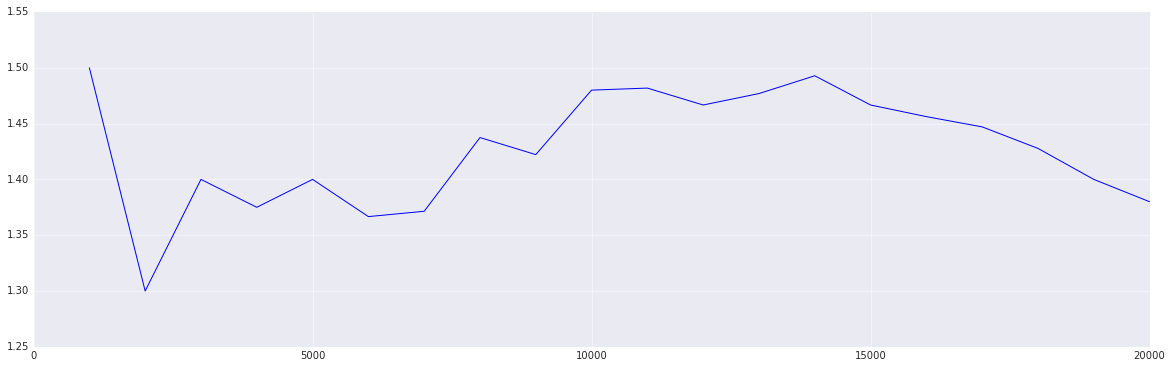

In [9]:
fl.plot_winning_percentage(rand_game_df)

## Q-Learning via table

In [10]:
state_dict = False

In [11]:
state_dict, q_table_game_df = fl.run_n_games(1000, fl.FrozenLakeQTable(), state_dict)

100%|██████████| 1000/1000 [00:01<00:00, 930.51it/s]


In [12]:
fl.print_game_stats(q_table_game_df)

Total number of moves: 27697
Number of moves per game: 27.697
Total number of games won: 267.0
Percentage of games won: 26.7


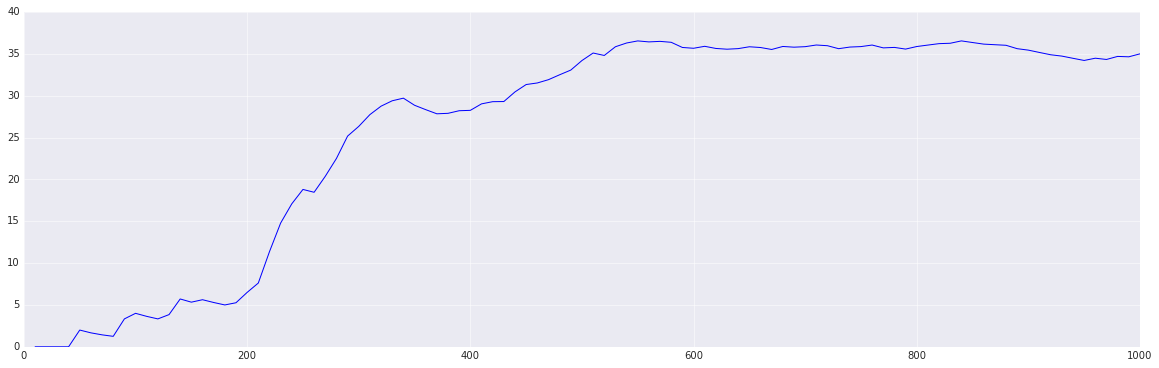

In [13]:
fl.plot_winning_percentage(q_table_game_df, gap = 10)

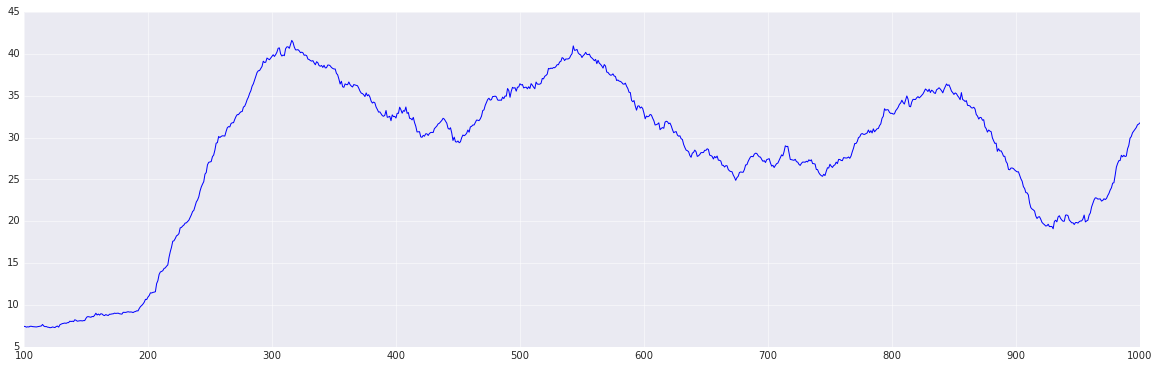

In [14]:
fl.plot_game_length(q_table_game_df, window = 100)

In [20]:
# run experiments
gamma_options = [0.95, 0.9, 0.8, 0.5]
learning_rate_options = [0.1, 0.5, 0.9, 1]
damper_options = [0.01, 0.001, 0.0001]

game_dfs = []

for gamma in gamma_options:
    for learning_rate in learning_rate_options:
        for damper in damper_options:
            for exp_run in [0, 1, 2, 3, 4]:
                _, q_table_game_df = fl.run_n_games(2000, fl.FrozenLakeQTable(gamma, learning_rate, damper), False,  use_tqdm = False)
                q_table_game_df["gamma"] = gamma
                q_table_game_df["learning_rate"] = learning_rate
                q_table_game_df["damper"] = damper
                q_table_game_df["exp_run"] = exp_run
                game_dfs.append(q_table_game_df)

In [21]:
exp_game_df = pd.concat(game_dfs)

In [22]:
exp_game_gb = exp_game_df[["gamma", "learning_rate", "damper", "exp_run", "end_game", "reward"]]\
    .groupby(["gamma", "learning_rate", "damper", "exp_run"], as_index = False)\
    .agg(sum)
    
exp_game_gb["win_pcnt"] = 100.0 * exp_game_gb.reward / exp_game_gb.end_game

exp_game_stats = exp_game_gb.groupby(["gamma", "learning_rate", "damper"]).mean()

In [23]:
exp_game_stats.sort_values("win_pcnt", ascending = False)

exp_run  end_game  reward  win_pcnt
gamma learning_rate damper                                     
0.95  0.9           0.0010        2    2000.0   884.6     44.23
                    0.0001        2    2000.0   868.2     43.41
      0.5           0.0001        2    2000.0   799.6     39.98
0.90  0.9           0.0001        2    2000.0   752.8     37.64
0.95  0.5           0.0010        2    2000.0   589.8     29.49
0.90  0.5           0.0010        2    2000.0   510.2     25.51
      0.9           0.0010        2    2000.0   500.6     25.03
0.80  0.5           0.0001        2    2000.0   482.4     24.12
0.95  0.9           0.0100        2    2000.0   433.8     21.69
      0.5           0.0100        2    2000.0   390.8     19.54
0.90  0.5           0.0001        2    2000.0   365.2     18.26
0.95  0.1           0.0100        2    2000.0   326.6     16.33
0.80  0.1           0.0001        2    2000.0   316.6     15.83
      0.5           0.0010        2    2000.0   315.6     15.78
0.90  0.5           0.0100        2    2000.0   302.2     15.11
0.95  0.1           0.0001        2    2000.0   302.2     15.11
0.90  0.1           0.0001        2    2000.0   298.0     14.90
0.95  0.1           0.0010        2    2000.0   280.4     14.02
0.90  0.1           0.0010        2    2000.0   267.0     13.35
                    0.0100        2    2000.0   261.4     13.07
0.80  0.9           0.0001        2    2000.0   253.4     12.67
      0.1           0.0010        2    2000.0   239.2     11.96
      0.9           0.0010        2    2000.0   158.4      7.92
0.90  0.9           0.0100        2    2000.0   128.6      6.43
0.80  0.5           0.0100        2    2000.0   118.8      5.94
0.50  0.5           0.0001        2    2000.0   105.4      5.27
      0.1           0.0010        2    2000.0   104.6      5.23
                    0.0001        2    2000.0    98.2      4.91
0.80  0.1           0.0100        2    2000.0    92.6      4.63
0.50  0.5           0.0010        2    2000.0    85.4      4.27
0.80  0.9           0.0100        2    2000.0    79.6      3.98
0.50  0.1           0.0100        2    2000.0    74.6      3.73
      0.5           0.0100        2    2000.0    69.2      3.46
      0.9           0.0001        2    2000.0    56.0      2.80
                    0.0010        2    2000.0    53.2      2.66
0.90  1.0           0.0010        2    2000.0    48.6      2.43
0.50  0.9           0.0100        2    2000.0    46.8      2.34
      1.0           0.0010        2    2000.0    45.8      2.29
0.90  1.0           0.0001        2    2000.0    43.2      2.16
0.80  1.0           0.0001        2    2000.0    41.4      2.07
0.95  1.0           0.0100        2    2000.0    40.4      2.02
                    0.0001        2    2000.0    37.8      1.89
0.50  1.0           0.0001        2    2000.0    37.0      1.85
0.95  1.0           0.0010        2    2000.0    36.2      1.81
0.90  1.0           0.0100        2    2000.0    36.0      1.80
0.80  1.0           0.0010        2    2000.0    35.0      1.75
                    0.0100        2    2000.0    34.6      1.73
0.50  1.0           0.0100        2    2000.0    32.2      1.61

## Q learning with neural networks

In [13]:
flnn = fl.FrozenLakeNN()

In [14]:
state_dict = False

In [15]:
state_dict, q_nn_game_df = fl.run_n_games(2000, flnn, state_dict)

100%|██████████| 2000/2000 [01:02<00:00, 31.99it/s]


In [16]:
flnn.stop_sess()

In [17]:
fl.print_game_stats(q_nn_game_df)

Total number of moves: 62665
Number of moves per game: 31.3325
Total number of games won: 739.0
Percentage of games won: 36.95


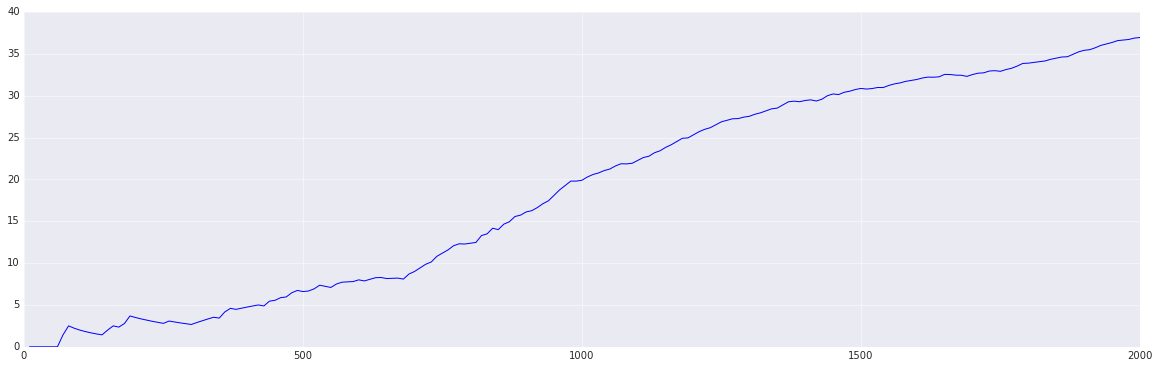

In [18]:
fl.plot_winning_percentage(q_nn_game_df, gap = 10)

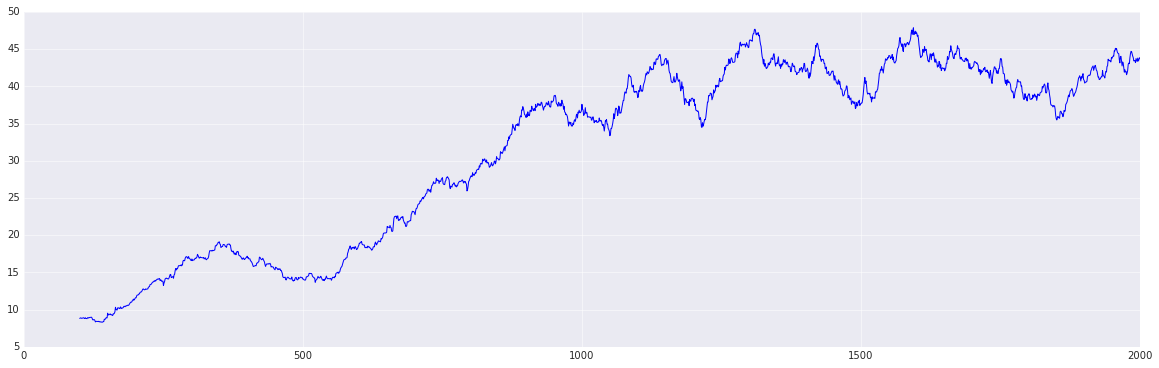

In [19]:
fl.plot_game_length(q_nn_game_df, window = 100)